# 2 _k_-Means Clustering

In this notebook, we will explore and cluster data with the _k_-Means algorithm.

In _k_-Means, a dataset is partitioned in _k_ clusters while trying to minimize the sum of squared distances of each point to its cluster center. One of the characteristics of this algorithm is that the number of clusters _k_ is predefined, i.e., the choice is left to the machine learning practitioner.

You can find an overview of the algorithm in the lecture slides.

As usual, we start with importing the packages:

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
np.random.seed(1337) # seeds help with reproducible results
%matplotlib inline

## 2.1 The Dataset
We are going to use a familiar dataset, the [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).
The dataset contains four features: sepal length, sepal width, petal length and petal width. We want to be able to look at our clustering results later. Four-dimensional data are hard to visualize for human brains. Thankfully, we know a handy dimensionality reduction technique, i.e., Principal Component Analysis (PCA).

### Task 2.1.1 Transform the Data
 1. Load the Iris Dataset.
 2. Use the PCA class from sklearn to project the dataset into a two-dimensional space.

In [35]:
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X_original = iris.data
y = iris.target

X_pca = PCA(n_components=2).fit_transform(X_original)

## 2.2 Initialization
Before we start with the learning phase, we need to set up a few initial parameters.

### Task 2.2.1 The _k_-Question
As mentioned, the choice of the right _k_ is an important decision for the success of the algorithm. The number of clusters you will retrieve in the end depends on _k_. Too many or too few clusters might give you suboptimal results.

Fortunately, we know that the Iris Dataset is labeled. Those labels already partition the data. Therefore, let's choose _k_ according to the number of labels.

In [21]:
print(iris.DESCR)
print("labels: ", y)
k = 3

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Task 2.2.2 The First Cluster Centers
You have to start somewhere! Theoretically, you could choose arbitrary points in the input space. Unfortunately, if we choose those randomly, the algorithm might take a while to converge.

In order to speed things up a little, let's choose different random datapoints from the dataset as the initial cluster centers.

_Hint: `numpy.random` has a few good functions for that purpose._

In [73]:
from numpy.random import default_rng
rng = default_rng()
#rng.integers(N)

X_pca_height, X_pca_width = X_pca.shape
def init_centroids():
    centroids = [rng.integers(X_pca_height) for _ in range(k)]
    centroids = [X_pca[i] for i in centroids]
    return centroids
centroids = init_centroids()

## 2.3 The Algorithm
Now the algorithm goes as follows:

    - obtain the distance of each point to each cluster center
    - assign that point to the nearest cluster
    - move position of centre to mean of points in cluster
    
Thus, we need a few calculation steps. Note that the use of libraries outside the Python Standard Library and `numpy` is not allowed in the following tasks, unless stated otherwise.

### Task 2.3.1 Compute the Distances
Complete the function `distances(...)` that takes a list/array of datapoints and a list/array of cluster centers and returns the distance of each data point to each cluster center.

In [49]:
def distances(X, centroids, ord=2):
    X_height, X_width = X.shape
    assert(X_width == 2)
    
    return [
        [
            np.linalg.norm(p-centroid, ord=ord)
            for centroid in centroids
        ]
        for p in X
    ]

### Task 2.3.2 Assign Data Points to Clusters
Now that we can compute the distances to the cluster centres, we need to assign the points to their respective clusters.

Complete the function `compute_assignments(...)` that takes a list/array of data points and a list/array of cluster centers and returns a list of assignments of each data point to the nearest cluster center.

_Hint: Make ample use of the `distances(...)` function you just wrote._

In [50]:
def compute_assignments(X, centroids):
    return [
        np.argmin(centroid_ds)
        for centroid_ds in distances(X, centroids)
    ]

### Task 2.3.3 Update Cluster Centers
Now that we have our clusters, we can compute new centers that better represent the cluster.

Complete the function `update_centers()` that takes takes a list/array of data points and a list/array of assignments and returns the new cluster centers.

In [64]:
def update_centers(X, assignments):
    X_height, X_width = X.shape
    return [
        np.mean([X[i] for i in range(X_height) if assignments[i] == cluster_i], axis=0)
        for cluster_i in range(k)
    ]

The most important parts are done! Theoretically, we only need to run the algorithm repeatedly until the cluster centers do not change anymore.

## 2.4 Cluster Quality
As we have seen in previous assignments, blindly running an algorithm without evaluating the quality of its results is not always the best idea.

Hence, we will use the Davies Bouldin (DB) Index to evaluate the quality of our clusters (see also the theory about the DB index in the lecture).

### Task 2.4.1 The Davies-Bouldin Index

Write a function `db_index(...)` that takes a list/array of data points, a list/array of cluster centers, and a list/array of assignments and returns the Davies-Bouldin Index.

You will need to:
    
    - calculate the radii of the clusters, R
    - calculate the inter class distance between the clusters
    - calculate the badness of separation between the clusters, D
    
Lastly, you need to take the average over the relevant D-values of each cluster.

All necessary formulas can be found in Lecture 19 (_Basic Clustering_).

In [54]:
def db_index(X, centroids, assignments):
    X_height, X_width = X.shape
    radii = [
        np.mean([
            (X[i] - centroids[cluster_i]) ** 2
            for i in range(X_height) if assignments[i] == cluster_i
        ])
        for cluster_i in range(k)
    ]
    def inter_class_distance(cluster_i, cluster_j):
        return np.linalg.norm(centroids[cluster_i] - centroids[cluster_j], ord=2)
    def badness_of_separation(cluster_i, cluster_j):
        return (radii[cluster_i] + radii[cluster_j]) / inter_class_distance(cluster_i, cluster_j)
    def worst_separation(cluster_i):
        return np.max([badness_of_separation(cluster_i, j) for j in range(k) if j != cluster_i])
    return np.mean([
        worst_separation(cluster_i) for cluster_i in range(k)
    ])

## 2.5 Learning Phase

### Task 2.5.1 Iterative Clustering
Finally, we have all the ingredients in order to cluster our data. Remember, we already initialized the first cluster centers.

Therefore, for 20 iterations, you will need to:

    - compute the cluster assignments
    - compute the new cluster centres according to the assignments
    - compute the DB index for the current assignments and cluster centers
    
Do not forget to log relevant data for each iteration:

    - the cluster centers
    - the cluster assignments
    - the DB-Index

In [76]:
centroids = init_centroids()

iteration_count = 20
assignments_log = []
centroids_log = []
db_index_log = []
for iteration in range(iteration_count):
    #print("centroids.pre", centroids)
    
    #print("distances", distances(X_pca, centroids))
    assignments = compute_assignments(X_pca, centroids)
    #print("assignments", assignments)
    centroids = update_centers(X_pca, assignments)
    #print("post", centroids)
    dbi = db_index(X_pca, centroids, assignments)
    
    assignments_log = np.append(assignments_log, assignments)
    centroids_log = np.append(centroids_log, centroids)
    db_index_log = np.append(db_index_log, dbi)

## 2.6 Evaluation

### Task 2.6.1 Plotting the DB-Index
Plot the DB Index over the iterations. Don't forget to add title, axis ticks, and axis labels to the plot!

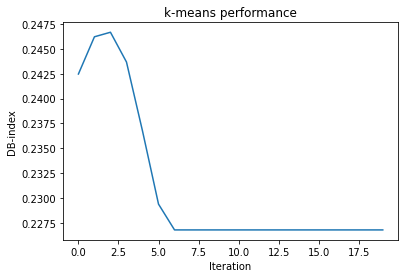

In [78]:
plt.plot(range(iteration_count), db_index_log)#, label="DB-index")
plt.title("k-means performance")
plt.xlabel("Iteration")
plt.ylabel('DB-index')
#plt.legend()
plt.show()

### Task 2.6.2 Clustered Data vs. Labeled Data
In the beginning, we told our _k_-Means algorithm to separate the data into _k_ clusters after determining _k_ based on the number of cluss labels in the dataset.

Create two plots side-by-side (using subplots), where one side is showing the clustered data and the other side is showing the partitions of the labeled data. 

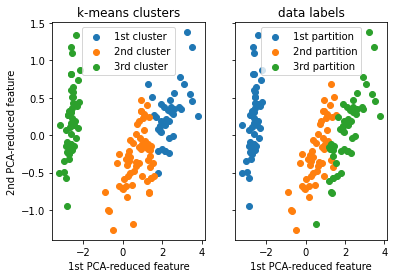

In [102]:
X_pca_kmeans_x = [
    [X_pca[i, 0] for i in range(X_pca_height) if assignments[i] == cluster_i]
    for cluster_i in range(k)
]

X_pca_kmeans_y = [
    [X_pca[i, 1] for i in range(X_pca_height) if assignments[i] == cluster_i]
    for cluster_i in range(k)
]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(X_pca_kmeans_x[0], X_pca_kmeans_y[0], label="1st cluster")
ax1.set_xlabel("1st PCA-reduced feature")
ax1.set_ylabel("2nd PCA-reduced feature")
ax1.set_title("k-means clusters")
ax1.legend()

ax1.scatter(X_pca_kmeans_x[1], X_pca_kmeans_y[1], label="2nd cluster")
ax1.legend()

ax1.scatter(X_pca_kmeans_x[2], X_pca_kmeans_y[2], label="3rd cluster")
ax1.legend()

X_pca_lbls_x = [
    [X_pca[i, 0] for i in range(X_pca_height) if y[i] == cluster_i]
    for cluster_i in range(k)
]

X_pca_lbls_y = [
    [X_pca[i, 1] for i in range(X_pca_height) if y[i] == cluster_i]
    for cluster_i in range(k)
]

ax2.set_title("data labels")
ax2.scatter(X_pca_lbls_x[0], X_pca_lbls_y[0], label="1st partition")
ax2.set_xlabel("1st PCA-reduced feature")
ax2.legend()

ax2.scatter(X_pca_lbls_x[1], X_pca_lbls_y[1], label="2nd partition")
ax2.legend()

ax2.scatter(X_pca_lbls_x[2], X_pca_lbls_y[2], label="3rd partition")
ax2.legend()

plt.show()

## 2.7 _k_-Means in the Wild
It is quite fun to write the _k_-Means algorithm bottom-up. But, usually, a practitioner would rely on libraries, which have already implemented the algorithm, if possible.
_k_-Means is implemented in the `scikit-learn` library, so we are going to use it to cluster somewhat more complex data and visualize the cluster centers.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans

### Task 2.7.1 Digits Data and the _k_-Question
Load the [Digits Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) and decide on a reasonable number of cluster centers.

In [ ]:
# your code here

### Task 2.7.2 Run the _k_-Means Algorithm
Use the provided _k_-Means object on the digits data and extract the cluster centers.

In [ ]:
# your code here

### 2.7.3 Plot the Cluster Centers
Plot all the extracted cluster centers as images.

In [ ]:
# your code here

Now you have implemented the _k_-Means algorithm bottom-up as well as using the corresponding libraries in a sensible way. Good work!